In [39]:
import sys
sys.path.append("..")

In [40]:
import numpy as np
import gmsh
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import scipy.interpolate
import scipy.sparse
import pytictoc

from femns2d import femns2d

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def create_tube(L=10, r=0.5, pfactor=0.1, name="tube.msh"):
    gmsh.initialize()
    gmsh.model.add('tube')
    
    if hasattr(r, '__len__'):
        rup, rdown = r[0], r[1]
    else:
        rup = rdown = r
    # Create points for unit square corners
    gmsh.model.geo.addPoint(0, -1, 0, pfactor, 1)
    gmsh.model.geo.addPoint(L/4-rdown, -1, 0, pfactor, 2)
    gmsh.model.geo.addPoint(L/4, -1+rdown, 0, pfactor, 3)
    gmsh.model.geo.addPoint(L/4+rdown, -1, 0, pfactor, 4)
    gmsh.model.geo.addPoint(L, -1, 0, pfactor, 5)
    gmsh.model.geo.addPoint(0, 1, 0, pfactor, 10)
    gmsh.model.geo.addPoint(L/4-rup, 1, 0, pfactor, 9)
    gmsh.model.geo.addPoint(L/4, 1-rup, 0, pfactor, 8)
    gmsh.model.geo.addPoint(L/4+rup, 1, 0, pfactor, 7)
    gmsh.model.geo.addPoint(L, 1, 0, pfactor, 6)
    gmsh.model.geo.addPoint(L/4, -1, 0, pfactor, 11)
    gmsh.model.geo.addPoint(L/4, 1, 0, pfactor, 12)

    gmsh.model.geo.addLine(1, 2, 1)
    
    gmsh.model.geo.addCircleArc(2, 11, 3, 2)
    gmsh.model.geo.addLine(3, 11, 3)
    gmsh.model.geo.addLine(11, 5, 4)
    gmsh.model.geo.addLine(5, 6, 5)
    gmsh.model.geo.addLine(6, 7, 6)
    gmsh.model.geo.addCircleArc(7, 12, 8, 7)
    gmsh.model.geo.addCircleArc(8, 12, 9, 8)
    gmsh.model.geo.addLine(9, 10, 9)
    gmsh.model.geo.addLine(10, 1, 10)
    
    # Create Curve Loop and Plane Surface
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 1)
    gmsh.model.geo.addPlaneSurface([1], 1)

    # Add physical lines for the boundaries
    gmsh.model.geo.addPhysicalGroup(1, [1, 2, 3, 4], 1)
    gmsh.model.geo.addPhysicalGroup(1, [5], 2)
    gmsh.model.geo.addPhysicalGroup(1, [6, 7, 8, 9], 3)
    gmsh.model.geo.addPhysicalGroup(1, [10], 4)    
    # Add physical group for the surface
    gmsh.model.geo.addPhysicalGroup(2, [1], 5)

    # Synchronize model and define mesh size
    gmsh.model.geo.synchronize()

    # Generate 2D mesh
    gmsh.model.mesh.generate(2)

    # Save mesh
    gmsh.write('tube.msh')

    gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Circle)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Circle)
Info    : [ 70%] Meshing curve 8 (Circle)
Info    : [ 80%] Meshing curve 9 (Line)
Info    : [ 90%] Meshing curve 10 (Line)
Info    : Done meshing 1D (Wall 0.00208821s, CPU 0.003311s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.141273s, CPU 0.141257s)
Info    : 2831 nodes 5668 elements
Info    : Writing 'tube.msh'...
Info    : Done writing 'tube.msh'



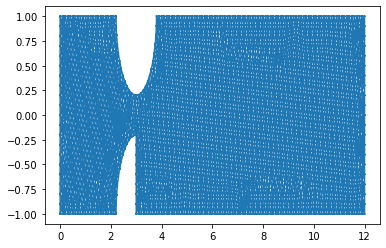

In [43]:
# Read the mesh file
tube_length = 12
choke_radius = 0.8
point_factor = 0.1
create_tube(tube_length, choke_radius, point_factor)
mesh = meshio.read("tube.msh")

# Plot the mesh
fig, ax = plt.subplots()
ax.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"])

plt.show()

In [44]:
Re = 30.0
steps = 1000
tol = 1e-3
velocity_cap = None
Re_init = 0.1
Re_schedule = np.linspace(0.1, Re, steps)

In [45]:
# dirichlet_bcs_u = [[0, 0], [1, 3]]
# dirichlet_bcs_v = [[0, 0], [1, 3]]
# dirichlet_bcs_p = [[5, 0], [4, 2]]
tictoc = pytictoc.TicToc()
tictoc.tic()
for Re in [10.0, 20.0, 30.0, 40.0, 50.0]:
    Rei = Re
    assembler = femns2d.MiniAssembler(mesh)
    ex = np.array([1.0, 0.0])
    ey = np.array([0.0, 1.0])
    K = assembler.stiffness_matrix()
    Azero = scipy.sparse.dok_matrix((assembler.npointse, assembler.npointse))
    Azerop = scipy.sparse.dok_matrix((assembler.npoints, assembler.npoints))
    Guxp = -Rei*assembler.pressure_velocity_convection_matrix(ex).T
    Guyp = -Rei*assembler.pressure_velocity_convection_matrix(ey).T
    Gpux = -Rei*assembler.velocity_pressure_convection_matrix(ex).T
    Gpuy = -Rei*assembler.velocity_pressure_convection_matrix(ey).T
    for step in range(steps):
        if step == 0: #Initial solution, Stokes in practice
            Ginertia = scipy.sparse.dok_matrix((assembler.npointse, assembler.npointse))
        else:
            ue = assembler.get_element_velocities(uxyp)
            Ginertia = Rei*assembler.convection_matrix(lambda i :ue[i], velocity_fn_type='element')
        KG = K + Ginertia
        Au = scipy.sparse.bmat([[KG, Azero, Guxp]])
        Av = scipy.sparse.bmat([[Azero, KG, Guyp]])
        Ap = scipy.sparse.bmat([[Gpux, Gpuy, Azerop]])
        A = scipy.sparse.bmat([[Au], [Av], [Ap]])
        A = scipy.sparse.dok_matrix(A)
        u_bc_func = lambda x : 1-(x[..., 1]**2)
        velocity_markers = [4, 1, 3]
        ux_values = [u_bc_func, 0, 0]
        uy_values = [0, 0, 0]
        pmarkers = [2]
        pvalues = [0.0]
        dirichlet_bcs_u = [ux_values, velocity_markers]
        dirichlet_bcs_v = [uy_values, velocity_markers]
        dirichlet_bcs_p = [pvalues, pmarkers]

        A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_p[1], A, 'p', excluded_markers=velocity_markers)
        A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_u[1], A, 'u')
        A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_v[1], A, 'v')
        A_sparse = A.tocsc()

        f = np.hstack([assembler.forcing_vector(0.0),
                       assembler.forcing_vector(0.0),
                       assembler.forcing_vector(0.0)[:assembler.npoints]])

        f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_p, f, 'p', excluded_markers=velocity_markers)
        f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_u, f, 'u')
        f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_v, f, 'v')
        uxyp_new = scipy.sparse.linalg.spsolve(A_sparse, f)
        if velocity_cap is not None:
            ux, uy, p = assembler.split_velocities(uxyp_new)
            velocities = np.sqrt(ux**2 + uy**2)
            normalizations = np.clip(velocities/velocity_cap, 1.0, None)
            normalizations = np.hstack([normalizations, normalizations, np.ones(assembler.npoints)])
            uxyp_new /= normalizations
        if step == 0:
            uxyp = uxyp_new.copy()
            uxyp_stokes = uxyp.copy()
            print(step, "FIRST STEP")
        else:
            duxyp = uxyp_new - uxyp
            error = np.max(np.abs(duxyp))
            uxyp = uxyp_new.copy()
            print(step, error)
            if error < tol:
                break
        
    tictoc.toc()
    np.savez(f"results_ns/results_choked_long_notdumb_{Re}.npz", uxyp=uxyp, uxyp_stokes=uxyp_stokes)


0 FIRST STEP
1 8.912848876157922
2 1.293928170473964
3 0.37393101385382543
4 0.08718207745616802
5 0.017709654215254833
6 0.0050388363564790595
7 0.002161666876310475
8 0.00101719119180399
9 0.0004698000049092599
Elapsed time is 383.362965 seconds.
0 FIRST STEP
1 7.909913216718513
2 2.1109125132609776
3 0.6541672680810569
4 0.23046678713237762
5 0.11928644188573956
6 0.0904780773268632
7 0.07222892364740652
8 0.05905389521516491
9 0.04893134245739983
10 0.0406650704432745
11 0.03391517051647708
12 0.028216904886912753
13 0.02342593972571616
14 0.019413193858101696
15 0.016068467749849713
16 0.013284667521892501
17 0.010965012753282766
18 0.009038323443286922
19 0.007442188875277367
20 0.006122603146283767
21 0.005033427301157634
22 0.004135613007438144
23 0.0033963324619545876
24 0.0027881246538243865
25 0.002288107936022632
26 0.0018772763311527552
27 0.0015398830868582625
28 0.0012629084635176202
29 0.0010356052892144252
30 0.000849114186735278
Elapsed time is 1550.051635 seconds.
0 

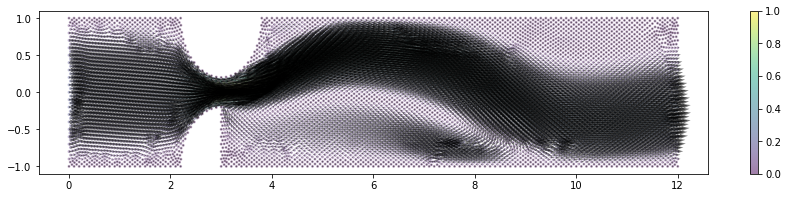

In [46]:
x, y = assembler.pointse[:, 0], assembler.pointse[:, 1]
ux, uy, p = assembler.split_velocities(uxyp)

plt.figure(figsize=(5*3, 3))
plt.scatter(assembler.pointse[:, 0], assembler.pointse[:, 1], s=4,
            c=np.sqrt(ux**2 + uy**2), cmap='viridis', alpha=0.25)
plt.quiver(x, y, ux, uy, angles='xy', scale_units='xy', scale=5, alpha=0.5)
plt.colorbar()

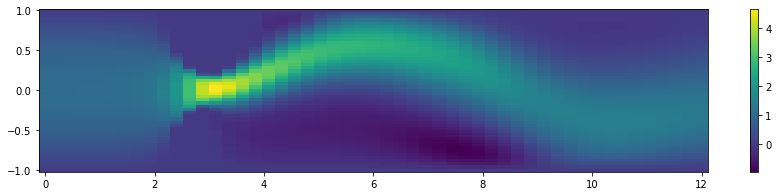

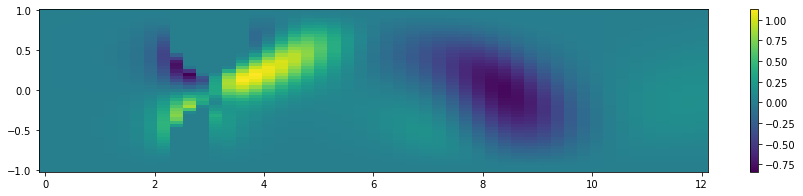

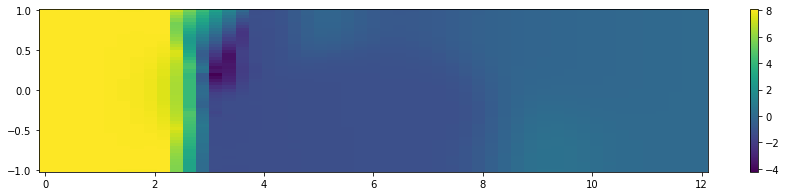

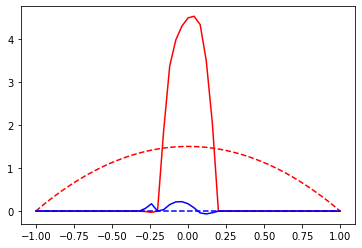

In [47]:
ux, uy, p = assembler.split_velocities(uxyp)
ux_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], ux)
uy_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], uy)
p_interp = scipy.interpolate.LinearNDInterpolator(assembler.points[:, :-1], p)

X, Y = np.meshgrid(np.linspace(0, 12, 51), np.linspace(-1, 1, 51))
UX = ux_interp(X, Y)
UY = uy_interp(X, Y)
P = p_interp(X, Y)
for Z in [UX, UY, P]:
    plt.figure(figsize=(5*3, 3))
    plt.pcolormesh(X, Y, Z, shading='auto')
    plt.colorbar()

n = 51
x = np.ones(n)*3.0
y = np.linspace(-1, 1, n)
ux = ux_interp(x, y)
uy = uy_interp(x, y)

plt.figure()
plt.plot(y, ux, 'r')
plt.plot(y, uy, 'b')
plt.plot(y, 1.5*(1-y**2), 'r--')
plt.plot(y, 0.0*y, 'b--')